In [35]:
import torch
import torch.nn as nn
from torch import Tensor

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

data = xr.open_dataset('./data/florence_2018.nc')

In [36]:
sst = data['sst'].values
print(type(sst))
#np_sst = sst.to_numpy()
#sst_tensor = torch.from_numpy(np_sst)
tensor = Tensor

def normalize(x: tensor) -> Tensor:
    tensor = x
    valid_mask = ~torch.isnan(tensor)
    valid_tensor = tensor[valid_mask]

    min_val = valid_tensor.min()
    max_val = valid_tensor.max()

    normalized_tensor = (0.1 * (max_val - tensor) + 0.9 * (tensor - min_val)) / (max_val - min_val)
    return normalized_tensor

<class 'numpy.ndarray'>


In [37]:
## transforming the original ncdf data into torch tensors to run through model
sst = data['sst']
np_sst = sst.to_numpy()
sst_tensor = torch.from_numpy(np_sst)

sst_tensor = sst_tensor.unsqueeze(0)

tensor = sst_tensor

tensor = normalize(tensor)
lat = sst.coords['latitude'].values
lon = sst.coords['longitude'].values
#print(tensor)
## create a mask that selects non-NaN values
valid_mask = ~torch.isnan(tensor)
valid_tensor = tensor[valid_mask]

##compute the min and max valeus over the valid elements
min_val = valid_tensor.min()
max_val = valid_tensor.max()

##normalization element wise equation
##this will produce NaN for positions where tensor already had NaN.
normalized_tensor = (0.1 * (max_val - tensor) + 0.9 * (tensor - min_val)) / (max_val - min_val)
print(normalized_tensor)

tensor([[[[   nan,    nan,    nan,  ..., 0.3793, 0.3775, 0.3711],
          [   nan,    nan,    nan,  ..., 0.3881, 0.3874, 0.3793],
          [   nan,    nan,    nan,  ..., 0.3908, 0.3905, 0.3856],
          ...,
          [   nan,    nan,    nan,  ..., 0.6716, 0.6628, 0.6501],
          [   nan,    nan,    nan,  ..., 0.6704, 0.6668, 0.6626],
          [0.7228,    nan,    nan,  ..., 0.6652, 0.6692, 0.6727]],

         [[   nan,    nan,    nan,  ..., 0.3793, 0.3775, 0.3711],
          [   nan,    nan,    nan,  ..., 0.3881, 0.3874, 0.3793],
          [   nan,    nan,    nan,  ..., 0.3908, 0.3905, 0.3856],
          ...,
          [   nan,    nan,    nan,  ..., 0.6716, 0.6628, 0.6501],
          [   nan,    nan,    nan,  ..., 0.6704, 0.6668, 0.6626],
          [0.7228,    nan,    nan,  ..., 0.6652, 0.6692, 0.6727]],

         [[   nan,    nan,    nan,  ..., 0.3793, 0.3775, 0.3711],
          [   nan,    nan,    nan,  ..., 0.3881, 0.3874, 0.3793],
          [   nan,    nan,    nan,  ..., 0

In [23]:
class Conv_SST(nn.Module):
    def __init__(self, in_feat, out_feat, kernel_size=2):
        super(Conv_SST,self).__init__()
        self.conv_2d = nn.Conv2d(in_feat, out_feat, kernel_size)
    
    def forward(self, x):
        return self.conv_2d(x)
    
class MaxPool_SST(nn.Module):
    def __init__(self):
        super(MaxPool_SST, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        return self.maxpool(x)
    
class AvgPool_SST(nn.Module):
    def __init__(self):
        super(AvgPool_SST, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        return self.avgpool(x)

In [24]:
print(normalized_tensor.shape)
tensor = normalized_tensor

torch.Size([1, 32, 141, 281])


In [25]:
conv = Conv_SST(in_feat=32, out_feat=32, kernel_size=2)
conv_output = conv(tensor)

maxpool = MaxPool_SST()
max_output = maxpool(tensor)

avgpool = AvgPool_SST()
avg_output = avgpool(tensor)

In [26]:
pooled_output = torch.cat([max_output, avg_output])

##output[first_batch , first channel, all rows, all columns]
conv_data = conv_output[0,0,:,:].detach().cpu().numpy()
max_data = max_output[0,0,:,:].detach().cpu().numpy()
avg_data = avg_output[0,0,:,:].detach().cpu().numpy()
pooled_data = pooled_output[0,0,:,:].detach().cpu().numpy()

print(conv_data.shape)
print(max_data.shape)
print(avg_data.shape)
print(pooled_data.shape)


(140, 280)
(70, 140)
(70, 140)
(70, 140)


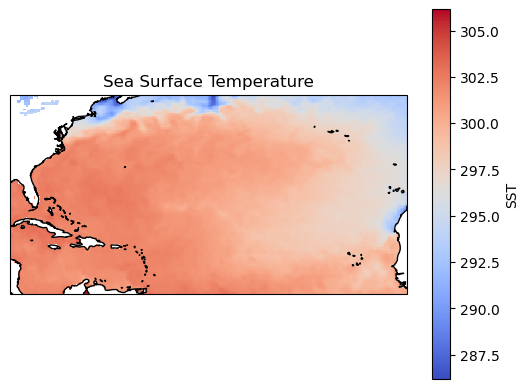

In [27]:
# Choose one valid_time index to plot (e.g., index 0)
sst_slice = sst.isel(valid_time=0).values  # shape (141, 281)

# Create a figure and axes using the PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# pcolormesh requires 2D lat/lon or 1D lat/lon + 2D data
# For 1D lat/lon, xarray automatically interprets them in order.
im = ax.pcolormesh(lon, lat, sst_slice, cmap='coolwarm',transform=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Add a colorbar
fig.colorbar(im, ax=ax, orientation='vertical', label='SST')

plt.title("Sea Surface Temperature")
plt.show()

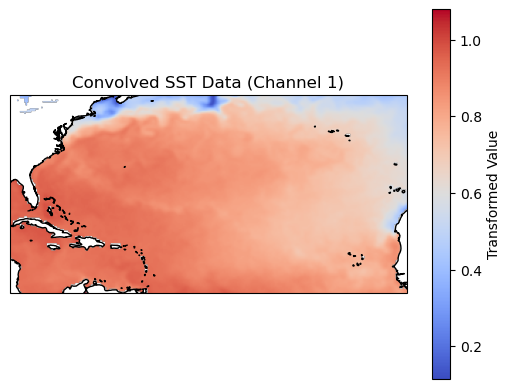

In [28]:
## extent = the size of the figure
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

## create a plot with a geographic projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
## use imshow to plot the data (origin 'upper' may be needed depending on your grid orientation)
im = ax.imshow(conv_data, extent=extent, origin='upper', cmap='coolwarm', transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Convolved SST Data (Channel 1)")
plt.colorbar(im, ax=ax, orientation='vertical', label='Transformed Value')
plt.show()

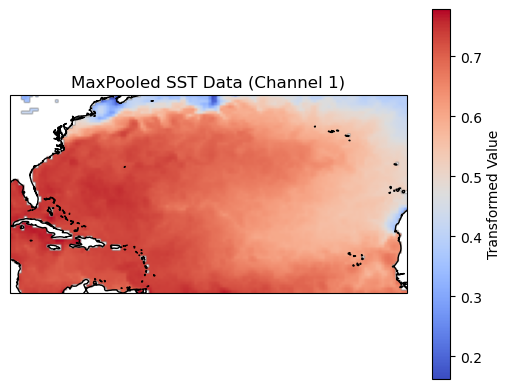

In [29]:
## create a plot with a geographic projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
## use imshow to plot the data (origin 'upper' may be needed depending on your grid orientation)
im = ax.imshow(max_data, extent=extent, origin='upper', cmap='coolwarm', transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("MaxPooled SST Data (Channel 1)")
plt.colorbar(im, ax=ax, orientation='vertical', label='Transformed Value')
plt.show()

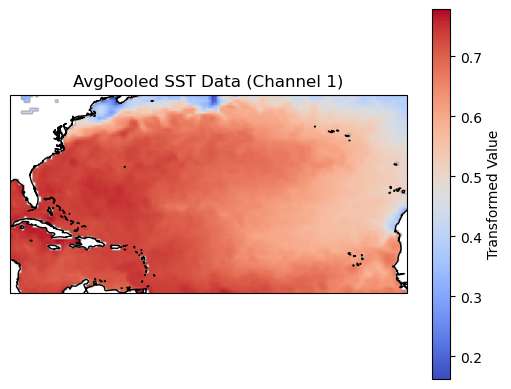

In [30]:
## create a plot with a geographic projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
## use imshow to plot the data (origin 'upper' may be needed depending on your grid orientation)
im = ax.imshow(pooled_data, extent=extent, origin='upper', cmap='coolwarm' ,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("AvgPooled SST Data (Channel 1)")
plt.colorbar(im, ax=ax, orientation='vertical', label='Transformed Value')
plt.show()

In [31]:
"""
basic implementation of the model from the paper this
"""
class SpatialAttention2D(nn.Module):
    def __init__(self):
        super(SpatialAttention2D, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2) ## maxpool operation takes max values from kernel_size of each tensor
        self.avgpool = nn.AvgPool2d(kernel_size=2) ##average pool operation takes average value from kernel_size of each tensor
        self.conv = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2) ## conv operation takes values and multiplies them against each other
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        ## utilizes the operation
        m_out = self.maxpool(x)
        a_out = self.avgpool(x)

        ## combining the outputs/features
        combined_feats = torch.add(m_out, a_out)
        print(combined_feats.shape) ## showing the shape of data after first set of operations
        first_conv = self.conv(combined_feats)

        mp2_feats = self.maxpool(first_conv)
        avp2_feats = self.avgpool(first_conv)

        ## combining the 2nd set of features
        feats_two = torch.add(mp2_feats, avp2_feats)
        print(feats_two.shape) ## showing the shape of data after second set of operations

        final = self.conv2(feats_two)
        print(final.shape) ## showing the final shape of the data
        return final

In [32]:
torch.manual_seed(1)

model = SpatialAttention2D()
output = model(tensor)
print(output)
"""
output continues to have nan values for sst data due to the overland temp values not being available.
attempting to add a mask in the forward method of the model would probably help. 
"""

torch.Size([1, 32, 70, 140])
torch.Size([1, 64, 34, 69])
torch.Size([1, 32, 33, 68])
tensor([[[[    nan,     nan,     nan,  ...,  0.3249,  0.3265,  0.3267],
          [    nan,     nan,     nan,  ...,  0.3413,  0.3423,  0.3339],
          [    nan,     nan,     nan,  ...,  0.3552,  0.3617,  0.3472],
          ...,
          [    nan,     nan,  0.4871,  ...,  0.4323,     nan,     nan],
          [    nan,     nan,  0.4885,  ...,  0.4370,     nan,     nan],
          [    nan,     nan,  0.4926,  ...,  0.4451,     nan,     nan]],

         [[    nan,     nan,     nan,  ...,  0.4520,  0.4427,  0.4545],
          [    nan,     nan,     nan,  ...,  0.5014,  0.4946,  0.4923],
          [    nan,     nan,     nan,  ...,  0.5252,  0.5196,  0.5154],
          ...,
          [    nan,     nan,  0.8130,  ...,  0.6720,     nan,     nan],
          [    nan,     nan,  0.8142,  ...,  0.6933,     nan,     nan],
          [    nan,     nan,  0.8120,  ...,  0.7242,     nan,     nan]],

         [[    na

'\noutput continues to have nan values for sst data due to the overland temp values not being available.\nattempting to add a mask in the forward method of the model would probably help. \n'

In [33]:
## this is turning the model transformed data back into a 2D numpy array in order to plot
output_data = output[0,0,:,:].detach().cpu().numpy()
print(output_data.shape)

(33, 68)


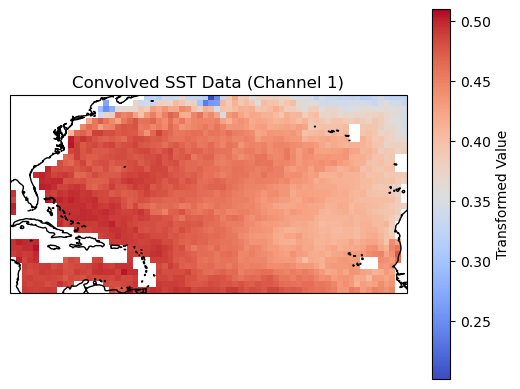

In [34]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.imshow(output_data, extent=extent, origin='upper', cmap='coolwarm', transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Convolved SST Data (Channel 1)")
plt.colorbar(im, ax=ax, orientation='vertical', label='Transformed Value')
plt.show()